In [5]:
## load required packages ##
import os
import matplotlib.pyplot as plt
import pylab as p
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
from os import listdir
import csv
import math
import pandas as pd
import scipy.integrate 
import scipy.io as sio
from IPython.core.display import display, HTML
from __future__ import division
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import IntProgress
from IPython.display import display
import time

In [6]:
## EDIT THIS SECTION | FILE & DIRECTORY INFO, HOUSEKEEPING ##
basedir1 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig5 quinine\\LHb"
basedir2 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig5 quinine\\VTA"
condition = ['LHb','VTA']
tastes=['Sucrose','Quinine']
projection='Both'

sucrosefile='sucrose_lick_align.npy'  #Lick aligned file name
quininefile='quinine_lick_align.npy'

filename='SucQuin_comp_proj_3s_window' ## name to be appended to saved files/figs

## Save Figures?
save_figs=['yes']

## Fig file type
fig_style='pdf' ##png, pdf, tif

## Save data files?
save_files=['yes']

maxnumneurons = 1000 #used to initialize arrays. Should be larger than the total number of neurons
framerate=5

### SET PARAMS FOR SUCROSE ANALYSIS ###
maxtrials=45    #number of trials
framespertrial=100 #frames per trial in lick align file
numpreframes=35 #frames before first lick
normalize_on=['yes'] ## normalize data by baseline?
baseline=[20,35]
test=[35,50] ##used to calc significance

## Color palatte ##
cmap=sns.diverging_palette(200, 275, sep=50, as_cmap=True, center='dark') ##Green-Purple
#cmap = sns.diverging_palette(230, 5, sep=20, as_cmap=True, center='dark') ###Teal-Pink
#cmap=sns.diverging_palette(220, 35, sep=100, as_cmap=True, center='dark') ###Teal-Gold

## Colors for bar/line plots (order reflects order of 'condition' above) ##
colors = ['lightseagreen','indigo']

In [7]:
## Do not edit - set path, create output directories, save params ##
os.chdir(basedir1)
os.chdir('..')
try:
    os.mkdir(filename+'_OUTPUT')
except OSError:
    print ("Creation of the directory %s failed" % filename+'_OUTPUT')
else:
    print ("Successfully created the directory %s " % filename+'_OUTPUT')
os.chdir(filename+'_OUTPUT')
try:
    os.mkdir('Behavior')
except OSError:
    pass
%pwd

#save parameters to csv
params=['Sucrose data: '+str(sucrosefile),'Quinine data: '+str(quininefile), 
        'Trials: '+str(maxtrials),'Frames per trial: '+str(framespertrial),
        'Lick occurs at frame: '+str(numpreframes), 'Normalize sucrose by baseline? '+str(normalize_on[0]),
        'Baseline period (frames): '+str(baseline), 'Test period (frames): '+str(test),
        'Framerate = '+str(framerate)]
with open(filename+'_analysis_parameters.csv','wb') as myfile:
    out=csv.writer(myfile,delimiter=',',dialect='excel',quoting=csv.QUOTE_ALL)
    out.writerow(params)

Creation of the directory SucQuin_comp_proj_3s_window failed_OUTPUT


In [8]:
## Do not edit - Load files in basedir1 and basedir2 ##
def load_files(directory,whichfile):
    signals_pop = np.nan*np.zeros((maxtrials,framespertrial,maxnumneurons))
    trials_pop=np.nan*np.zeros((maxnumneurons))
    data_dirs = os.walk(directory).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        try:
            signals=np.load(os.path.join(directory,data_dir,whichfile))
        except:
            continue
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        numtrials=signals.shape[0]
        for a in range(0,numneurons):
            signals_pop[0:numtrials,0:signals.shape[1],numneuronstillnow+a]=signals[0:maxtrials,:,a]
            trials_pop[numneuronstillnow:numneuronstillnow+a+1]=numtrials
        numneuronstillnow += numneurons
    extractedsignals=signals_pop[:,:,:numneuronstillnow]
    trials_pop=trials_pop[:numneuronstillnow]
    print '\nfiles = '+str(data_dirs)
    print 'Number of neurons = '+str(extractedsignals.shape[2])
    print 'Number of frames per trial = '+str(extractedsignals.shape[1])
    return extractedsignals,numneuronstillnow,numframes,numneurons,numtrials,trials_pop
extractedsignals1_suc,numneuronstillnow1_suc,numframes1_suc,numneurons1_suc,numtrials1_suc,trials_pop1_suc=load_files(basedir1,sucrosefile)
extractedsignals2_suc,numneuronstillnow2_suc,numframes2_suc,numneurons2_suc,numtrials2_suc,trials_pop2_suc=load_files(basedir2,sucrosefile)

extractedsignals1_quin,numneuronstillnow1_quin,numframes1_quin,numneurons1_quin,numtrials1_quin,trials_pop1_quin=load_files(basedir1,quininefile)
extractedsignals2_quin,numneuronstillnow2_quin,numframes2_quin,numneurons2_quin,numtrials2_quin,trials_pop2_quin=load_files(basedir2,quininefile)


files = ['AH10', 'AH11', 'AH12', 'AH5', 'AH6']
Number of neurons = 147
Number of frames per trial = 100

files = ['AH13', 'AH14', 'AH7', 'AH8', 'AH9']
Number of neurons = 123
Number of frames per trial = 100

files = ['AH10', 'AH11', 'AH12', 'AH5', 'AH6']
Number of neurons = 147
Number of frames per trial = 100

files = ['AH13', 'AH14', 'AH7', 'AH8', 'AH9']
Number of neurons = 123
Number of frames per trial = 100


In [5]:
## Do not edit -  normalize data by baseline period ##
if normalize_on[0]=='yes':
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    extractedsignals1_sucnorm=normalize_data(extractedsignals1_suc)
    extractedsignals2_sucnorm=normalize_data(extractedsignals2_suc)
    extractedsignals1_quinnorm=normalize_data(extractedsignals1_quin)
    extractedsignals2_quinnorm=normalize_data(extractedsignals2_quin)
else:
    extractedsignals1_sucnorm=extractedsignals1_suc
    extractedsignals2_sucnorm=extractedsignals2_suc
    extractedsignals1_quinnorm=extractedsignals1_quin
    extractedsignals2_quinnorm=extractedsignals2_quin

In [6]:
## Do not edit - population heatmap function ## 
def plotpop(data1,data2,label,framespertrial):
    ymin=-.02
    ymax=.1
    
    avg_response1=np.nanmean(data1,axis=0)
    avg_response2=np.nanmean(data2,axis=0)
    avg_rew_response1=np.nanmean(avg_response1[test[0]:test[1],:],axis=0)
    avg_rew_response2=np.nanmean(avg_response2[test[0]:test[1],:],axis=0)
    
    #remove frames preceding start of baseline window
    avg_response1=avg_response1[baseline[0]:,:]
    avg_response2=avg_response2[baseline[0]:,:]
    framespertrial=framespertrial-baseline[0]
    
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 8})
    fig1,ax = plt.subplots(1,1,figsize=(8,5))
    sns.tsplot(avg_response1.T,color=colors[0], condition=label[0]+' (n = '+str(data1.shape[2])+')', legend=True)
    sns.tsplot(avg_response2.T,color=colors[1], condition=label[1]+' (n = '+str(data2.shape[2])+')', legend=True)
    ax.set_title('Avg response '+projection)
    ax.set_xlabel('Time from lick (s)')
    ax.set_ylabel('dF/F')
    ax.set_ylim(ymin,ymax)
    ax.set_xticks(range(5, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)])
    ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [ymin, ymax], '--k', linewidth=1)
    plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
    fig1.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig((filename+'_pop_'+str(label[0])+'_vs_'+str(label[1])+'.'+fig_style), format=str(fig_style))
        plt.show()
        


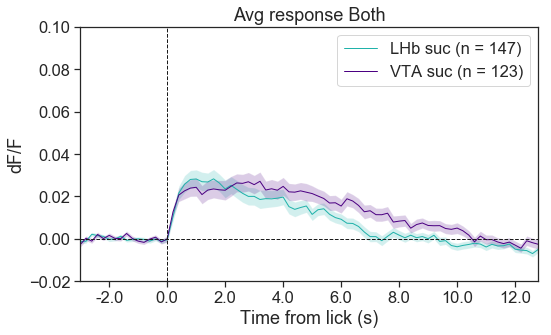

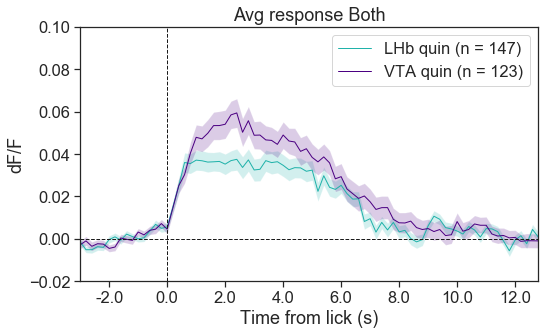

In [8]:
## Fig 5H (bottom): Average population responses ## 
plotpop(extractedsignals1_sucnorm,extractedsignals2_sucnorm,label=['LHb suc','VTA suc'],framespertrial=framespertrial)
plotpop(extractedsignals1_quinnorm,extractedsignals2_quinnorm,label=['LHb quin','VTA quin'],framespertrial=framespertrial)

In [9]:
## Do not edit - SVM classifier ##
def suc_quin_svm(sucdata, quindata, numsuctrials, numquintrials, split, label):
    print 'Running SVM classifier on dataset: ', condition[label]
    
    parameters = [{'C': [0.001, .01,.1,1,10,100,1000], 'kernel': ['linear']},
                  {'C': [0.001, .01,.1,1,10,100,1000], 'gamma': [0.001, .01,.1,1,10,100,1000], 'kernel': ['rbf']}]
    
    sucdata=sucdata[:numsuctrials,test[0]:test[1],:]
    quindata=quindata[:numquintrials,test[0]:test[1],:]
    suctag=[0]*numsuctrials
    quintag=[1]*numquintrials
    
    pred_score=np.nan*np.zeros((sucdata.shape[2]))
    rand_score=np.nan*np.zeros((sucdata.shape[2]))
    
    f = IntProgress(min=0, max=sucdata.shape[2], step=1, description='Progress:') # instantiate progress bar
    display(f) # display the bar

    for i in range(sucdata.shape[2]):
        tempsuc=pd.DataFrame(sucdata[:,:,i])
        tempquin=pd.DataFrame(quindata[:,:,i])
        tempsuc['trial']=suctag
        tempquin['trial']=quintag
        df=pd.concat([tempsuc, tempquin])
        df=df.dropna(axis=0)
        
        ##randomly subset df into test and train sets
        msk = np.random.rand(len(df))>split
        train = df[msk]
#         print ('train set = ', train.shape)
        clf = GridSearchCV(SVC(), parameters,cv=10)
        train_labels=train[['trial']].values
        c,r=train_labels.shape
        train_labels=train_labels.reshape(c,)
        clf.fit(train.iloc[:,:test[1]-test[0]], train_labels)
#         print 'prediction accuracy = ', clf.best_score_
        pred_score[i]=(clf.best_score_)*100
        ##random array of 1s and 0s for shuffled classifier
        rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
        clf.fit(train.iloc[:,:test[1]-test[0]], rand_group[0])
#         print 'shuffled accuracy = ', clf.best_score_
        rand_score[i]=(clf.best_score_)*100
        
        f.value += 1 # signal to increment the progress bar
        
    d,p=stats.ks_2samp(pred_score,rand_score)
    plt.figure(figsize=(5,5))
    ax=plt.subplot(111)
    # n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score)) #Proportion of Cells
    n=np.arange(1,len(pred_score)+1) # Number of Cells
    Xs = np.sort(pred_score)
    plt.step(Xs,n,color='g',label='Model',alpha=0.7,linewidth=2)
    # n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score)) #Proportion of Cells
    n2= np.arange(1,len(rand_score)+1) #Number of Cells
    Xs2= np.sort(rand_score)
    plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)

    plt.xlabel('Prediction accuracy %',fontsize=20)
    plt.ylabel('Number of cells',fontsize=20)
    plt.title('K-S test Results: '+str("D={0:.7f}".format(round(d,3)))+' , '+str("p={0:.7f}".format(round(p,3))),fontsize=14)
    plt.legend(fontsize=14,loc=2)
    if save_figs[0]=='yes':
        plt.savefig(filename+'_split'+str(split)+'_'+condition[label]+'_SVM_prediction_accuracy_hist.'+fig_style, format=str(fig_style))
        np.savetxt(filename+'_split'+str(split)+'_'+condition[label]+'_SVM_prediction_accuracy.csv',pred_score,delimiter=',')
        np.savetxt(filename+'_split'+str(split)+'_'+condition[label]+'_SVM_RANDOM_prediction_accuracy.csv',rand_score,delimiter=',')
    plt.show()

    print 'Average model accuracy: ', round(np.nanmean(pred_score),2),'%'
    print 'Average random accuracy: ', round(np.nanmean(rand_score),2),'%' '\n'
    return pred_score, rand_score

In [10]:
## Fig 5L: SVM decoding to determine if each cell distinguishes between sucrose and quinine ##
pred_score1, rand_score1 = suc_quin_svm(extractedsignals1_sucnorm,extractedsignals1_quinnorm, numtrials1_suc, numtrials1_quin, 0.3,label=0)
pred_score2, rand_score2 = suc_quin_svm(extractedsignals2_sucnorm,extractedsignals2_quinnorm, numtrials2_suc, numtrials2_quin, 0.3,label=1)

In [11]:
## combine groups and plot on same heatmap ##
def combinedheatmap(data1,data2,title,sorton):
    data1=np.nanmean(data1,axis=0)
    data2=np.nanmean(data2,axis=0)
    data1=data1[20:,:]
    data2=data2[20:,:]
    
    ymin=-.1
    ymax=.1
    if sorton=='yes':
        sort1=np.squeeze(np.argsort(np.nanmean(data1[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0])], axis=0, keepdims=True)))
        data1=data1[:,sort1]
        sort2=np.squeeze(np.argsort(np.nanmean(data2[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0])], axis=0, keepdims=True)))
        data2=data2[:,sort2]       
    data=np.concatenate((data1,data2),axis=1)
    
    ylabel1=range(0,data1.shape[1]+1,10)
    ylabel2=range(10,data2.shape[1]+1,10)
    ylabels=ylabel1+ylabel2
    
    fig2 = plt.figure(2,figsize=(8,7))
    cbar_ax = fig2.add_axes([.52, .2, .02, .6])
    cbar_ax.tick_params(width=0.5) 
    
    ax = plt.subplot(121)
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    sns.heatmap(data.T, cmap=cmap, vmin=ymin, vmax=ymax,linewidth=0,cbar_ax=cbar_ax,rasterized=True)
    cbar_ax.set_ylabel('dF/F')
    ax.set_title(filename+' '+str(condition[0]), fontsize=16,position=[0.5,1.05])
    ax.set_xlabel('Time from lick (s)', fontsize=14)
    ax.set_xticks(range(5, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
    ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, data.shape[1]], '--w', linewidth=1)
    ax.axhline(y=data1.shape[1], color='white', linewidth=2)
    ax.set_yticks(range(0, data.shape[1]+1, 10))
    ax.set_yticklabels(ylabels,fontsize='14')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    plt.ylabel('ROIs', fontsize='16')
    
    ## control text boxes
    offset=[82,12] ##related to specified plot size. change as needed
    
    ## bottom text box
    ax.text(offset[0],offset[1], '                '+condition[0]+'                  '
            ,fontsize=16,color=colors[0],rotation=270
            ,bbox={'facecolor':colors[0],'alpha':0.3,'pad':4})
    
    ## top text box
    ax.text(offset[0],offset[1]+data1.shape[1]+1, '             '+condition[1]+'                '
            ,fontsize=16,color=colors[1],rotation=270
            ,bbox={'facecolor':colors[1],'alpha':0.5,'pad':4})
    
    fig2.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig((filename+'_'+title+'.'+fig_style), format=str(fig_style))
    plt.show()

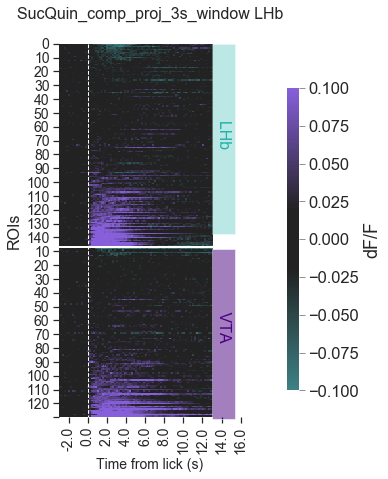

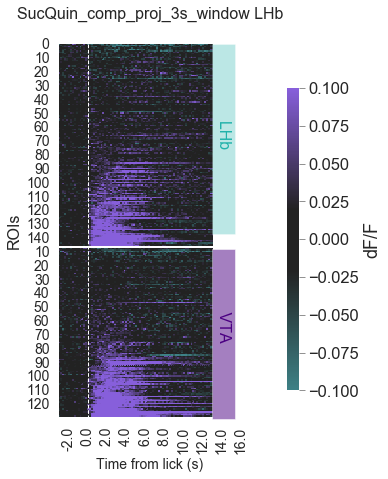

In [12]:
## Fig 5H (top): Population heatmaps
combinedheatmap(extractedsignals1_sucnorm,extractedsignals2_sucnorm,"combined_SUC_pop_heatmap_sorted",sorton='yes')
combinedheatmap(extractedsignals1_quinnorm,extractedsignals2_quinnorm,"combined_QUIN_pop_heatmap_sorted",sorton='yes')

In [13]:
## Do not edit - bar graph function ##
def bar_plot(data1,data2,ytitle,param,leg):
    if param=='Median':
        try:
            if data1.shape[1]>0:
                data1=np.nanmedian(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmedian(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmedian(data1)
        means[:,1]=np.nanmedian(data2)
        means=np.squeeze(means)
        try:
            t,p=np.around(stats.wilcoxon(data1,data2),decimals=3)
            test='Wilcoxon Rank Sum'
        except:
            t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
            test='t-test'
        sems=np.nan*np.zeros((1,2))
        sems[:,0]= stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)
    else:
        test='t-test'
        try:
            if data1.shape[1]>0:
                data1=np.nanmean(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmean(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmean(data1)
        means[:,1]=np.nanmean(data2)
        means=np.squeeze(means)
        t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
        sems=np.nan*np.zeros((1,2))
        sems[:,0]=stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)
    combinedata=np.nan*np.zeros((max(data1.shape[0],data2.shape[0]),2))
    combinedata[:data1.shape[0],0]=data1
    combinedata[:data2.shape[0],1]=data2
    
    ind = (0,.5)
    width = 0.4
    fig,ax=plt.subplots(1,figsize=(3,6))
    bar=ax.bar(ind,means,width,yerr=sems,color=colors,error_kw={'ecolor':'black','linewidth':2})
    ax.set_ylabel(ytitle+' ('+param+')')
    ax.set_title(test+': '+str(t)+'  p = '+str(p),y=1,fontsize='16')
    ax.legend((bar[0],bar[1]),(leg[0],leg[1]),loc=[1.1,.5])
    ax.set_xticks([])
    if save_figs[0]=='yes':
        np.savetxt(filename+'_'+ytitle+'.csv', combinedata, delimiter=',')
        fig.savefig((filename+'_'+ytitle+'.'+fig_style), format=str(fig_style),bbox_inches='tight')
    plt.show()

In [14]:
## Do not edit - AUC function ##
def auc(data,label):
    data=np.nanmean(data, axis=0)
    AUC=np.nan*np.zeros((data.shape[1]))
    for i in range(0,data.shape[1]):
        AUC[i] = scipy.integrate.trapz(y=data[test[0]:test[1],i])        
    if save_files[0]=='yes':
        np.savetxt(filename+'_AUC_'+label+'response_.csv',AUC.T,delimiter=',')
    return AUC

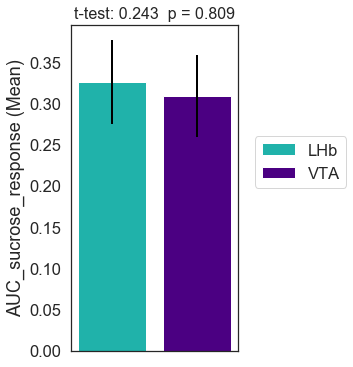

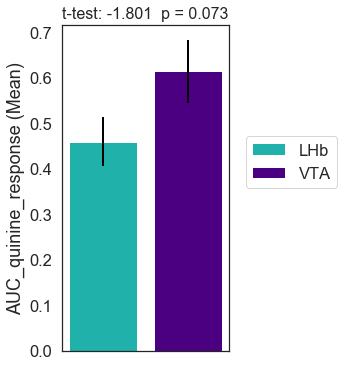

In [15]:
## Fig 5I,J: Response AUC ##
aucsuc1=auc(extractedsignals1_sucnorm,label='LHb suc')
aucsuc2=auc(extractedsignals2_sucnorm,label='VTA suc')
aucquin1=auc(extractedsignals1_quinnorm,label='LHb quin')
aucquin2=auc(extractedsignals2_quinnorm,label='VTA quin')

bar_plot(aucsuc1,aucsuc2,'AUC_sucrose_response',param='Mean',leg=condition)
bar_plot(aucquin1,aucquin2,'AUC_quinine_response',param='Mean',leg=condition)
# bar_plot(aucsuc1,aucquin1,'AUC_LHb_suc_quin',param='Mean',leg=tastes)
# bar_plot(aucsuc2,aucquin2,'AUC_VTA_suc_quin',param='Mean',leg=tastes)

In [16]:
## Do not edit - Function to compare conditions and pie chart function ##
def compare2conditions(data1, data2,test_type,sig_pvalue,test_window,cond):
    avgresponse=np.nan*np.zeros((data1.shape[0],data1.shape[2],2))
    message=[]
    for a in range(data1.shape[2]):
        for b in range(data1.shape[0]):
            temp1=data1[b,test_window[0]:test_window[1],a]
            temp2=data2[b,test_window[0]:test_window[1],a]
            avgresponse[b,a,0]=np.nanmean(temp1)
            avgresponse[b,a,1]=np.nanmean(temp2)

    avgresponse_stats=np.nan*np.zeros((data1.shape[2],2))
    for a in range(data1.shape[2]):
        temp1=avgresponse[:,a,0];temp1=temp1[~np.isnan(temp1)]
        temp2=avgresponse[:,a,1];temp2=temp2[~np.isnan(temp2)]
        if test_type=='independent':
            avgresponse_stats[a,:]=stats.ttest_ind(temp1,temp2,equal_var=False)
            testused='Independent t-test'
        if test_type=='paired':
            try:
                avgresponse_stats[a,:]=stats.ttest_rel(temp1,temp2)
                testused='Paired t-test'
            except:
                message= "*** Numbers not equal between conditions. Reverting to independent t-test ***"
                avgresponse_stats[a,:]=stats.ttest_ind(temp1,temp2,equal_var=False)
                testused='Independent t-test'
        if test_type=='wilcoxon':
            try:
                avgresponse_stats[a,:]=stats.wilcoxon(temp1,temp2,zero_method='wilcox')
                testused='Wilcoxon Rank Sum'
            except:
                message= "*** Numbers not equal between conditions. Reverting to Mann-Whitney U ***"
                avgresponse_stats[a,:]=stats.mannwhitneyu(temp1,temp2,alternative='two-sided')
                testused='Mann-Whitney U'

    print(message if len(message)>0 else ' ')
    def find_sig_cells(data,stats,label):
        sig_excited_neurons_temp=np.nan*np.zeros((data.shape[1]))
        sig_inhibited_neurons_temp=np.nan*np.zeros((data.shape[1]))
        for a in range(0,data.shape[1]):
            sig_excited_neurons_temp[a] = np.logical_and(stats[a,1]<sig_pvalue,np.nanmean(data[:,a,0])<np.nanmean(data[:,a,1])) ##condition1 less than condition2 = excited
            sig_inhibited_neurons_temp[a] = np.logical_and(stats[a,1]<sig_pvalue,np.nanmean(data[:,a,0])>np.nanmean(data[:,a,1])) ##condition1 greater than condition2 = inhibited

        num_excited=np.nansum(sig_excited_neurons_temp)
        num_inhibited=np.nansum(sig_inhibited_neurons_temp)
        no_change=(data.shape[1]-(num_excited+num_inhibited))

        ##plot pie chart of responses
        labels = 'No response', 'Positive\nresponse', 'Negative\nresponse'
        colors=[(0.7, 0.7,0.7),'c',(0.84, 0.35, 0.35)]
        explode=(0, .2, .2)
        frequency_population = np.zeros((3,4)) #3 response types x 4 trial types
        frequency_response = np.array([no_change, num_excited, num_inhibited])
        frequency_population[:,0] = frequency_response
        print "Projection: "+condition[cond]
        print "Data used: "+label +" response"
        print "Test: "+testused, "| P threshold: "+str(sig_pvalue)
        print "Excited = ",num_excited
        print "Inhibited = ",num_inhibited
        print "Null = ",no_change
        fig9,ax1 = plt.subplots(figsize=(7,5))
        ax1.set_title(filename+' '+condition[cond]+' response between conditions', y=1)
        ax1.pie(frequency_response, explode=explode, autopct='%1.0f%%',
                shadow=True, startangle=45, colors=colors)
        plt.tight_layout()
        if save_figs[0]=='yes':
            plt.savefig((filename+'_'+condition[cond]+'_pie_between_conditions.'+fig_style), format=str(fig_style))
            np.savetxt(filename+'_'+condition[cond]+'_SIG_EXCITED_SUCvQUIN_IND.csv',sig_excited_neurons_temp,delimiter=',')
            np.savetxt(filename+'_'+condition[cond]+'_SIG_INHIBITED_SUCvQUIN_IND.csv',sig_inhibited_neurons_temp,delimiter=',')
        plt.show()
        return sig_excited_neurons_temp, sig_inhibited_neurons_temp

    excited_avg,inhibited_avg=find_sig_cells(avgresponse, avgresponse_stats,label='avg')
    return excited_avg, inhibited_avg   

*** Numbers not equal between conditions. Reverting to Mann-Whitney U ***
Projection: LHb
Data used: avg response
Test: Mann-Whitney U | P threshold: 0.05
Excited =  22.0
Inhibited =  3.0
Null =  122.0


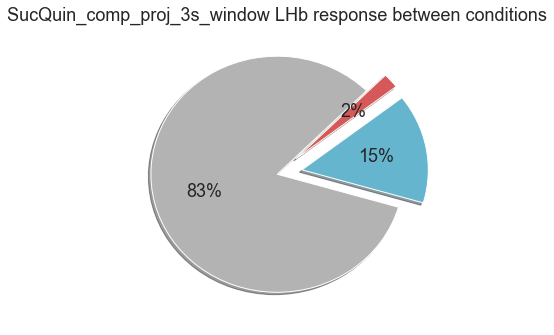

*** Numbers not equal between conditions. Reverting to Mann-Whitney U ***
Projection: VTA
Data used: avg response
Test: Mann-Whitney U | P threshold: 0.05
Excited =  43.0
Inhibited =  4.0
Null =  76.0


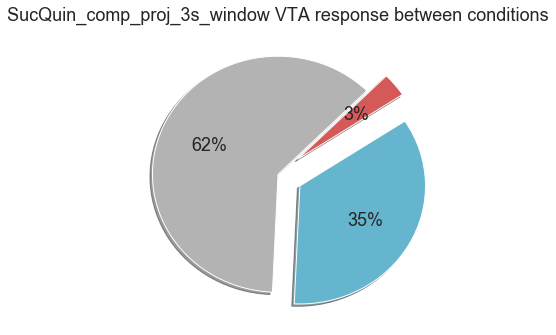

In [17]:
## Fig 5K: Cell responsivity ##
excited_avg1, inhibited_avg1=compare2conditions(extractedsignals1_sucnorm,extractedsignals1_quinnorm,test_type='wilcoxon',sig_pvalue=0.05,test_window=test,cond=0)
excited_avg2, inhibited_avg2=compare2conditions(extractedsignals2_sucnorm,extractedsignals2_quinnorm,test_type='wilcoxon',sig_pvalue=0.05,test_window=test,cond=1)

# Analyze licking behavior ##

In [18]:
## Do not edit - align lick data to first lick after reward and plot ##
def align_licks(basedir): 
    #initialize counters
    sucrosetrials=0
    quininetrials=0
    sucroselicktrials=0
    quininelicktrials=0
    
    #initialize arrays
    suclickprob=np.nan*np.zeros((maxnumneurons,framespertrial))
    suclickrate=np.nan*np.zeros((maxnumneurons,framespertrial))
    quinlickprob=np.nan*np.zeros((maxnumneurons,framespertrial))
    quinlickrate=np.nan*np.zeros((maxnumneurons,framespertrial))
    sucprob=np.nan*np.zeros((maxnumneurons,framespertrial))
    sucrate=np.nan*np.zeros((maxnumneurons,framespertrial))
    quinprob=np.nan*np.zeros((maxnumneurons,framespertrial))
    quinrate=np.nan*np.zeros((maxnumneurons,framespertrial))
    latencysucall=np.nan*np.zeros((maxnumneurons))
    latencyquinall=np.nan*np.zeros((maxnumneurons))
    
    data_dirs = os.walk(basedir).next()[1]
    licktotal=np.nan*np.zeros((len(data_dirs))) ; q=0
    for data_dir in data_dirs:
        try:
            behaviordata=sio.loadmat(os.path.join(basedir,data_dir,'behavior.mat'))
        except:
            continue
        cues=np.squeeze(behaviordata['cues'])
        licks=np.squeeze(behaviordata['licks'])
        t_fxd=np.squeeze(behaviordata['fxdpumps'])#/1000 #in seconds
        eventlog = behaviordata['eventlog']
        tempframes = eventlog[eventlog[:,0]==9,1]
        sucrose = eventlog[eventlog[:,0]==5,1]+3000 #Add 3s to account for time between "cue" timestamp and liquid delivery
        quinine = eventlog[eventlog[:,0]==6,1]+3000 #Add 3s to account for time between "cue" timestamp and liquid delivery
        frameaveraging = 6
        framerate = 30.0/frameaveraging #for resonant scanner, maximum rate is 30Hz
        frames = tempframes[::frameaveraging]
        cuesplus=cues[cues>0]
        
        def findfirstlick(data):
            firstlick=np.nan*np.zeros((len(data)))
            for a in range(0,len(data)):
                try:
                    if data[a]-licks[licks>data[a]][1] < -10000:
                        firstlick[a] = np.nan
                    elif data[a]-licks[licks>data[a]][0] == -51:
                        firstlick[a] = licks[licks>data[a]][1] #use second lick to avoid solenoid artifact
                    else:
                        firstlick[a] = licks[licks>data[a]][1] #use second lick to avoid solenoid artifact
                except:
                    pass
            return firstlick
        firstlickafterCSplus=findfirstlick(t_fxd)
        firstlickaftersucrose=findfirstlick(sucrose)
        firstlickafterquinine=findfirstlick(quinine)
        
        ## calculate latency to lick after reward delivery
        def get_lick_latency(lick,event):
            latency=np.nan*np.zeros((lick.shape))
            for i in range(len(event)):
                temp=(lick[i]-event[i])/1000
                if temp<10:
                    latency[i]=temp
            latency=latency[~np.isnan(latency)]
            return latency
        latencyall=get_lick_latency(firstlickafterCSplus,t_fxd)
        latencysuc=get_lick_latency(firstlickaftersucrose,sucrose)
        latencyquin=get_lick_latency(firstlickafterquinine,quinine)
   
        ##find frame numbers
        def framenumberforevent(event):
            framenumber = np.nan*np.zeros(event.shape)
            for ie, e in enumerate(event):
                try:
                    framenumber[ie] = np.nonzero(frames<=e)[0][-1]
                except:
                    pass
            return framenumber
        framenumberforcuesplus = np.squeeze(framenumberforevent(cuesplus))
        framenumberforlicks = np.squeeze(framenumberforevent(licks))
        framenumberforCSpluslick = np.squeeze(framenumberforevent(firstlickafterCSplus))
        framenumberforrew=np.squeeze(framenumberforevent(t_fxd))
        framenumberforCSpluslick=framenumberforCSpluslick[~np.isnan(framenumberforCSpluslick)]
        framenumberforquinine=np.squeeze(framenumberforevent(quinine))
        framenumberforsucrose=np.squeeze(framenumberforevent(sucrose))
        framenumberforsucroselick=np.squeeze(framenumberforevent(firstlickaftersucrose))
        framenumberforquininelick=np.squeeze(framenumberforevent(firstlickafterquinine))
        framenumberforsucroselick=framenumberforsucroselick[~np.isnan(framenumberforsucroselick)]
        framenumberforquininelick=framenumberforquininelick[~np.isnan(framenumberforquininelick)]
            
        def alignlickbehav(event):
            eventnum=event.shape[0]
            lickframes=np.zeros((t_fxd.shape[0]*125))
            lickframesrate=np.zeros((t_fxd.shape[0]*125))
            framesall=np.arange(0,lickframes.shape[0])
            numtimesampleslick = 100 #How many do you want to plot around the cue?
            for a in range(0,len(framesall)):
                for b in range(0,len(framenumberforlicks)):
                    if framenumberforlicks[b]==framesall[a]:
                        lickframes[a]=1 
                        lickframesrate[a]=lickframesrate[a]+1
            lickframesrate=lickframesrate*framerate
            alignlick_behavior = np.zeros([eventnum,framespertrial]) #for lick probability lick aligned
            alignlick_rate = np.zeros([eventnum,framespertrial]) #for lick rate lick aligned
            for i in range(event.shape[0]):
                try:
                    alignlick_behavior[i,:]= lickframes[int(event[i]-baseline[0]):int(event[i]+numtimesampleslick-baseline[0])]
                    alignlick_rate[i,:]= lickframesrate[int(event[i]-baseline[0]):int(event[i]+numtimesampleslick-baseline[0])]
                except:
                    templen=lickframes[int(event[i]-baseline[0]):].shape[0]
                    alignlick_behavior[i,:templen]= lickframes[int(event[i]-baseline[0]):]
                    alignlick_rate[i,:templen]= lickframesrate[int(event[i]-baseline[0]):]
            return alignlick_behavior, alignlick_rate                    
        
        suclickalign_prob, suclickalign_rate = alignlickbehav(framenumberforsucroselick) 
        quinlickalign_prob, quinlickalign_rate = alignlickbehav(framenumberforquininelick) 
        sucalign_prob, sucalign_rate = alignlickbehav(framenumberforsucrose) 
        quinalign_prob, quinalign_rate = alignlickbehav(framenumberforquinine) 
        
        suclickprob[sucroselicktrials:sucroselicktrials+framenumberforsucroselick.shape[0],:]=suclickalign_prob[:,:]
        suclickrate[sucroselicktrials:sucroselicktrials+framenumberforsucroselick.shape[0],:]=suclickalign_rate[:,:]
        quinlickprob[quininelicktrials:quininelicktrials+framenumberforquininelick.shape[0],:]=quinlickalign_prob[:,:]
        quinlickrate[quininelicktrials:quininelicktrials+framenumberforquininelick.shape[0],:]=quinlickalign_rate[:,:]
        
        sucprob[sucrosetrials:sucrosetrials+sucrose.shape[0],:]=sucalign_prob[:,:]
        sucrate[sucrosetrials:sucrosetrials+sucrose.shape[0],:]=sucalign_rate[:,:]
        quinprob[quininetrials:quininetrials+quinine.shape[0],:]=quinalign_prob[:,:]
        quinrate[quininetrials:quininetrials+quinine.shape[0],:]=quinalign_rate[:,:]
        
        latencysucall[sucroselicktrials:sucroselicktrials+framenumberforsucroselick.shape[0]]=latencysuc
        latencyquinall[quininelicktrials:quininelicktrials+framenumberforquininelick.shape[0]]=latencyquin
        
        sucrosetrials += sucalign_prob.shape[0]
        quininetrials += quinalign_prob.shape[0]
        sucroselicktrials += suclickalign_prob.shape[0]
        quininelicktrials += quinlickalign_prob.shape[0]
          
    latencysucall=latencysucall[:sucroselicktrials];latencysucall[~np.isnan(latencysucall)]    
    latencyquinall=latencyquinall[:quininelicktrials];latencyquinall[~np.isnan(latencyquinall)] 
    
    suclickprob=suclickprob[:sucroselicktrials,:]
    suclickrate=suclickrate[:sucroselicktrials,:]
    quinlickprob=quinlickprob[:quininelicktrials,:]
    quinlickrate=quinlickrate[:quininelicktrials,:]
    
    sucprob=sucprob[:sucrosetrials,:]
    sucrate=sucrate[:sucrosetrials,:]
    quinprob=quinprob[:quininetrials,:]
    quinrate=quinrate[:quininetrials,:]

    return latencysucall,latencyquinall,suclickprob,suclickrate,quinlickprob,quinlickrate,sucprob,sucrate,quinprob,quinrate 
        
latencysuc1,latencyquin1,suclickprob1,suclickrate1,quinlickprob1,quinlickrate1,sucprob1,sucrate1,quinprob1,quinrate1 =align_licks(basedir1)
latencysuc2,latencyquin2,suclickprob2,suclickrate2,quinlickprob2,quinlickrate2,sucprob2,sucrate2,quinprob2,quinrate2 =align_licks(basedir2)

In [19]:
## Do not edit - Funciton to plot lick data ##
def plotlickdata(data1,data2,xtitle,ylim,ylabel,leg):
    framestoplot=80
    data1=data1[:,:framestoplot]
    data2=data2[:,:framestoplot]
    
    fontsize=20
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    sns.set_style("ticks", {"xtick.major.size": 0, "ytick.major.size": 8})
    f,ax = plt.subplots(1,1,figsize=(10,5))
    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    sns.tsplot(data1[:,:], color=colors[0], condition=leg[0], legend=True)
    sns.tsplot(data2[:,:], color=colors[1], condition=leg[1], legend=True)
    ax.set_title(filename+' lick rate '+projection,fontsize=fontsize)
    ax.set_xlabel(xtitle+' (s)',fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_yticks(np.arange(ylim[0],ylim[1]+1,ylim[1]/2))
    ax.set_yticklabels(np.arange(ylim[0],ylim[1]+1,ylim[1]/2),fontsize=fontsize)
    ax.set_xticks(range(10, framestoplot+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framestoplot+1, 10)],fontsize=fontsize)
    ax.set_ylim([ylim[0],ylim[1]+.05])
    f.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig(('Behavior/'+filename+'_'+xtitle+'_'+ylabel+'.'+fig_style), format=str(fig_style))
        plt.show()

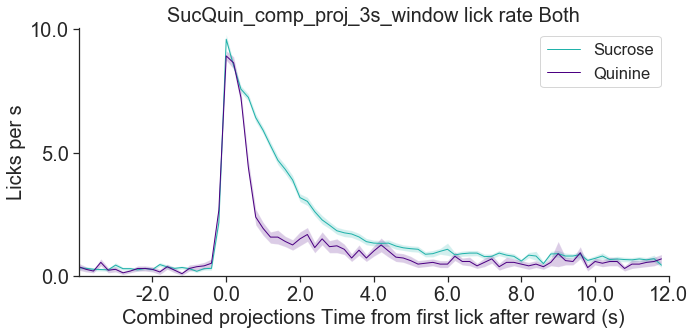

In [20]:
## Fig 5C: population lick rate ##
sucrate_combined=np.concatenate((suclickrate1,suclickrate2))
quinrate_combined=np.concatenate((quinlickrate1,quinlickrate2))

plotlickdata(sucrate_combined,quinrate_combined,'Combined projections Time from first lick after reward',ylim=[0,10],ylabel='Licks per s',leg=tastes)

In [6]:
## function to plot single neuron data ##
plotfont=20
sns.set(font_scale=2)
size=[5,15]

def plot_single_neurons(sucdata, quindata, condition, roinum,projection):
    i=roinum
    ## normalize data by baseline period ##
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]/BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    sucnorm=normalize_data(sucdata)
    quinnorm=normalize_data(quindata)
    
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    plt.clf()
    fig4 = plt.figure(4)
    fig4.set_figheight(size[0])
    fig4.set_figwidth(size[1])
    ax1 = plt.subplot(121)
    ax1=sns.heatmap(sucnorm[:,:,i], linewidth=0, cmap=cmap, vmin=.8, vmax=1.2, cbar_kws={'label': 'dF/F'},rasterized=True)
    trial_len=sucnorm.shape[0]
    ax1.set_title(projection+' ROI_'+str(i)+' '+condition[0], fontsize=plotfont)
    ax1.set_xlabel('Time from lick (s)',fontsize=plotfont)
    ax1.set_xticks(range(5, framespertrial+1, 10))
    ax1.set_xticklabels([str(((a-(baseline[1]-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize=plotfont)
    ax1.set_yticks(range(0, trial_len, 10))
    ax1.set_yticklabels([str(b) for b in range(trial_len, 0, -10)],fontsize=plotfont)
    ax1.plot([baseline[1], baseline[1]], [0, trial_len], '--w', linewidth=3)
    ax1.set_ylabel('Trial number',fontsize=plotfont)

    fig5 = plt.figure(4)
    ax2 = plt.subplot(122)
    fig5.set_figheight(size[0])
    fig5.set_figwidth(size[1])
    ax2=sns.heatmap(quinnorm[:,:,i], linewidth=0, cmap=cmap, vmin=.8, vmax=1.2, cbar_kws={'label': 'dF/F'},rasterized=True)
    trial_len=quinnorm.shape[0]
    ax2.set_title(projection+' ROI_'+str(i)+' '+condition[1], fontsize=plotfont)
    ax2.set_xlabel('Time from lick (s)',fontsize=plotfont)
    ax2.set_xticks(range(5, framespertrial+1, 10))
    ax2.set_xticklabels([str(((a-(baseline[1]-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize=plotfont)
    ax2.set_yticks(range(0, trial_len, 10))
    ax2.set_yticklabels([str(b) for b in range(trial_len, 0, -10)],fontsize=plotfont)
    ax2.plot([baseline[1], baseline[1]], [0, trial_len], '--w', linewidth=3)
    ax2.set_ylabel('Trial number',fontsize=plotfont)
    
    fig5.tight_layout(w_pad=2)
    if save_files[0]=='yes':
        plt.savefig((filename+'_'+projection+'_ROI_'+str(i)+'.pdf'), format='pdf')
        plt.show()
    else:
        plt.show()
        
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    fig7 = plt.figure(4)
    ax3 = plt.subplot(211)
    fig7.set_figheight(size[0]*2)
    fig7.set_figwidth(size[0]*2)
    ax3=sns.tsplot(np.nanmean(sucnorm[:,:,i],axis=0),linewidth=3,color='blue')
    ax3=sns.tsplot(np.nanmean(quinnorm[:,:,i],axis=0),linewidth=3,color='red')
    h = plt.gca().get_lines()
    plt.legend(handles=h, labels=condition,fontsize=20)
    ax3.set_title(filename+'_'+projection+'_ROI_'+str(i), fontsize=plotfont)
    ax3.set_xlabel('Time from lick (s)', fontsize=plotfont, labelpad=3)
    ax3.set_xticks(range(5, framespertrial+1, 10))
    ax3.set_xticklabels([str(((a-(baseline[1]-baseline[0])+5)/framerate)) for a in range(0, 
            framespertrial+1, 10)],fontsize=plotfont)
    plt.xticks(fontsize=plotfont)
    plt.yticks(fontsize=plotfont)
    plt.ylim([(np.min([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])-.1),
              (np.max([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])+.1)])
    plt.ylabel('dF/F', fontsize=plotfont)
    ax3.plot([baseline[1], baseline[1]],
             [(np.min([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])-.1),
              (np.max([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])+.1)], '--k', linewidth=2)
    plt.axhline(y=1, linestyle='--', linewidth=2, color='k')
    if save_files[0]=='yes':
        plt.savefig((filename+'_'+projection+'_ROI_'+str(i)+'_AVG.pdf'), format='pdf')
        plt.show()
    else:
        plt.show()

<Figure size 432x288 with 0 Axes>

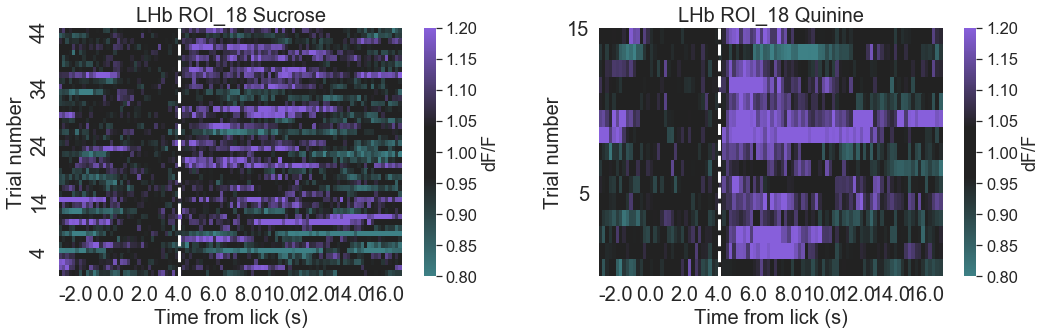

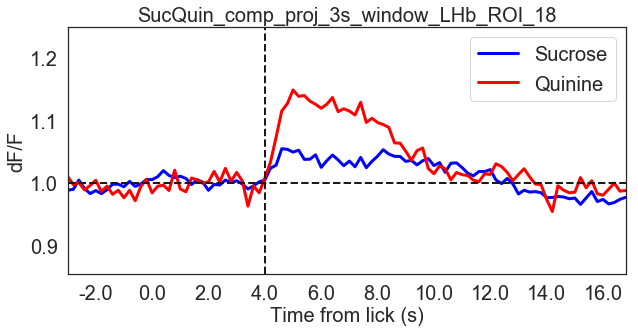

In [7]:
## Fig 5F: LHb example neuron ##
sucroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig5 quinine\\LHb\\AH10\\sucrose_lick_align.npy")
quinroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig5 quinine\\LHb\\AH10\\quinine_lick_align.npy")

plot_single_neurons(sucdata=sucroi, quindata=quinroi, condition=["Sucrose", "Quinine"],roinum=18,projection='LHb')

<Figure size 432x288 with 0 Axes>

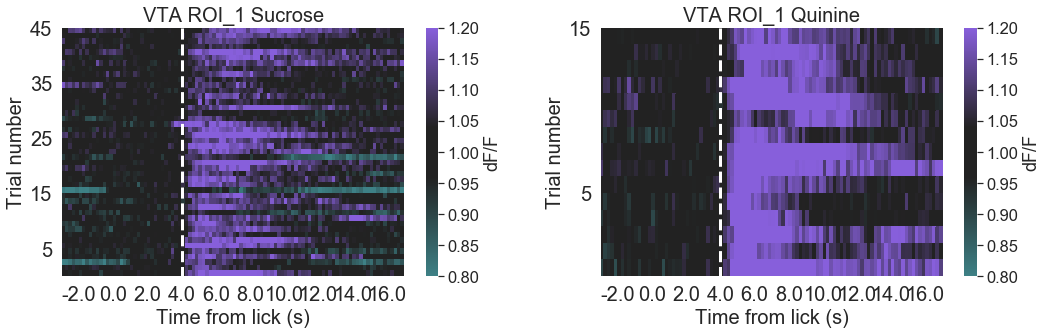

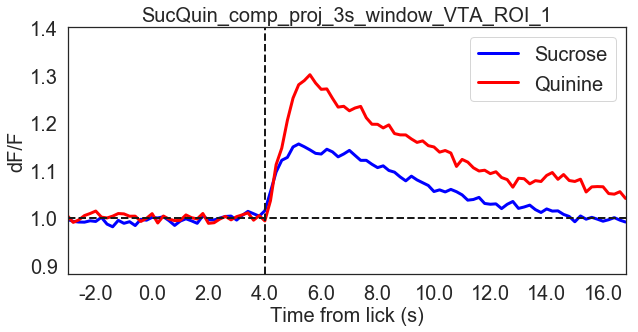

In [8]:
## Fig 5G: VTA example neuron ##
sucroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig5 quinine\\VTA\\AH9\\sucrose_lick_align.npy")
quinroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig5 quinine\\VTA\\AH9\\quinine_lick_align.npy")

plot_single_neurons(sucdata=sucroi, quindata=quinroi, condition=["Sucrose", "Quinine"],roinum=1,projection='VTA')